# Subspace Digital Twin, Sanity Checking Run

*Danilo Lessa Bernardineli, November 2023*

On this notebook, we do an sanity checking run (which is a single run) so that basic metrics and KPIs
for the simulation are computed.

## Part 1. Dependences & Set-up

In [1]:
import sys
sys.path.append('../')

import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import panel as pn
import seaborn as sns
import hvplot.pandas
import holoviews as hv
hvplot.extension('plotly')

import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = "png" # For GitHub rendering

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

## Part 2. Load Simulation Data

In [2]:
sim_df = pd.read_pickle(
    "../data/simulations/sanity_check_run-2024-01-02_10-16-07.pkl.gz"
)

In [3]:
sim_df.head(5)

,days_passed,blocks_passed,circulating_supply,user_supply,issued_supply,total_supply,sum_of_stocks,block_utilization,dsf_relative_disbursal_per_day,reward_issuance_balance,other_issuance_balance,operators_balance,nominators_balance,holders_balance,farmers_balance,staking_pool_balance,fund_balance,burnt_balance,nominator_pool_shares,operator_pool_shares,block_reward,history_size,space_pledged,allocated_tokens,buffer_size,reference_subsidy,average_base_fee,average_priority_fee,average_compute_weight_per_tx,average_transaction_size,transaction_count,average_compute_weight_per_bundle,average_bundle_size,bundle_count,compute_fee_volume,storage_fee_volume,rewards_to_nominators,simulation,subset,run,timestep,delta_days,delta_blocks,average_compute_weight_per_budle,label,environmental_label,timestep_in_days,block_time_in_seconds,max_credit_supply
0,0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,1.320000e+09,1.680000e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0,0,0.0,0.0,0.00000,0.0,0.0,0.0,256,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0,0,1,0,NaN,NaN,NaN,standard,standard,1,6,3000000000
14,1,14400.0,13.698630,13.698630,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,1.680000e+09,0.000000,0.000000,0.684932,13.013699,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.698630,0,1572944000000,0.0,97286400.0,13.69863,1.0,3.0,60000000.0,256,14400.0,0.0,0.0,86400.0,0.000000,0.000000,0.0,0,0,1,1,1.0,14400.0,1.000000e+10,standard,standard,1,6,3000000000
28,2,28800.0,27.363014,27.363014,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,1.680000e+09,0.003425,0.003425,1.686641,25.669524,0.000000,0.034247,0.000000e+00,0.000000,0.000000,13.698630,268435456,3145888000000,0.0,60355072.0,13.69863,1.0,3.0,60000000.0,256,14400.0,0.0,0.0,86400.0,0.000003,0.342466,0.0,0,0,1,2,1.0,14400.0,1.000000e+10,standard,standard,1,6,3000000000
42,3,43200.0,41.319709,41.319777,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,1.680000e+09,0.011654,0.011824,2.850101,38.446131,0.000068,0.118579,0.000000e+00,0.000034,0.000034,14.041096,536870912,4718832000000,0.0,23423744.0,13.69863,1.0,3.0,60000000.0,256,14400.0,0.0,0.0,86400.0,0.000003,0.843320,0.0,0,0,1,3,1.0,14400.0,1.000000e+10,standard,standard,1,6,3000000000
56,4,57600.0,55.718919,55.719222,1.680000e+09,1.680000e+09,3.000000e+09,0.000002,0.0,1.320000e+09,1.680000e+09,0.025211,0.025956,4.110654,51.557097,0.000303,0.261084,6.506784e-09,0.000152,0.000151,14.541950,536870912,6291776000000,0.0,120710144.0,13.69863,1.0,3.0,60000000.0,256,14400.0,0.0,0.0,86400.0,0.000003,1.425050,0.0,0,0,1,4,1.0,14400.0,1.000000e+10,standard,standard,1,6,3000000000


In [4]:
sim_df.groupby(['run', 'label', 'environmental_label']).size().reset_index(name='Days')

,run,label,environmental_label,Days
0,1,standard,standard,1097


## Part 3. Visualizations

On this section, we'll visualize some base metrics on the simulations results

In [5]:
# Ensure numeric types for plotly
for col in sim_df.columns:
    if "supply" in col or col == "sum_of_stocks":
        sim_df[col] = pd.to_numeric(sim_df[col], errors='coerce')

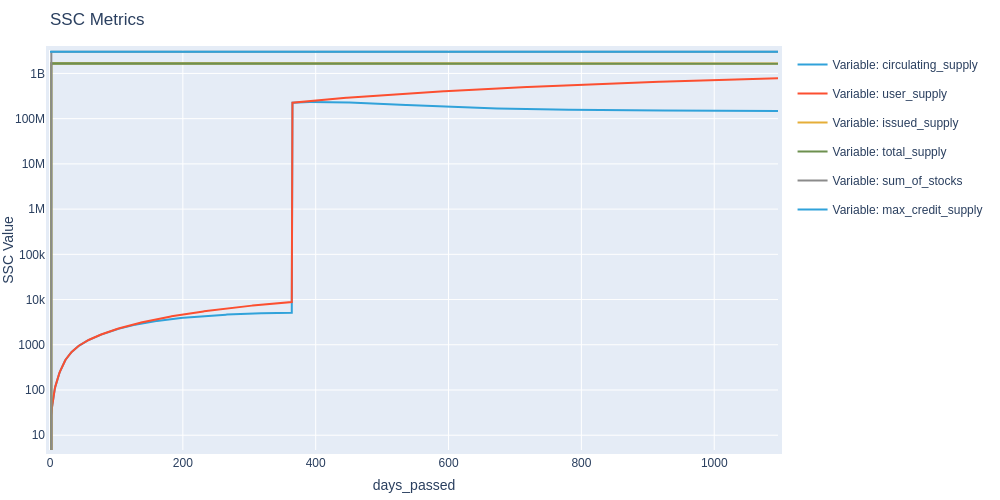

In [6]:
chart = sim_df.hvplot(
    x="days_passed", 
    y=[col for col in sim_df.columns if "supply" in col or col == "sum_of_stocks"], 
    title="SSC Metrics", logy=True, 
    ylabel="SSC Value", width=1000, height=500)

pio.show(hv.render(chart, backend='plotly'))

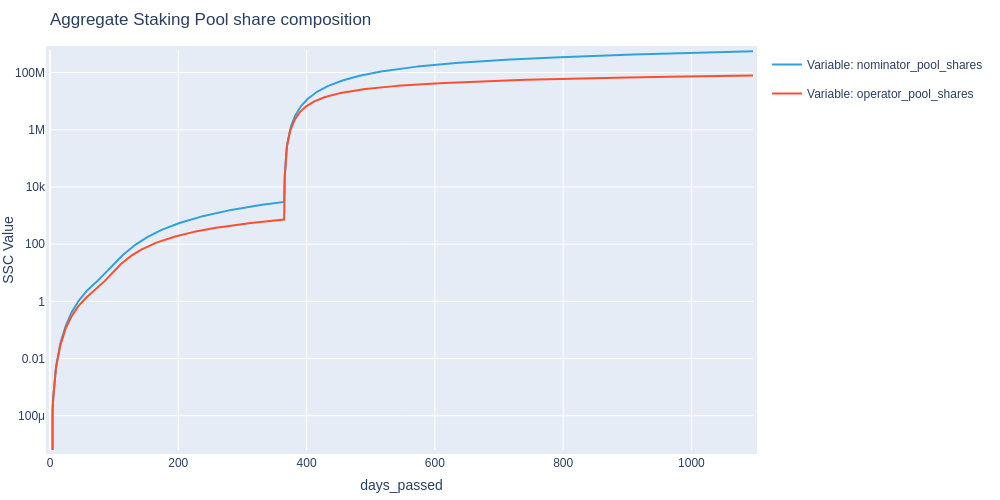

In [7]:
chart = sim_df.hvplot(
    x="days_passed", 
    y=[el for el in sim_df.columns if "shares" in el],
    title="Aggregate Staking Pool share composition", logy=True, 
    ylabel="SSC Value", width=1000, height=500)

pio.show(hv.render(chart, backend='plotly'))

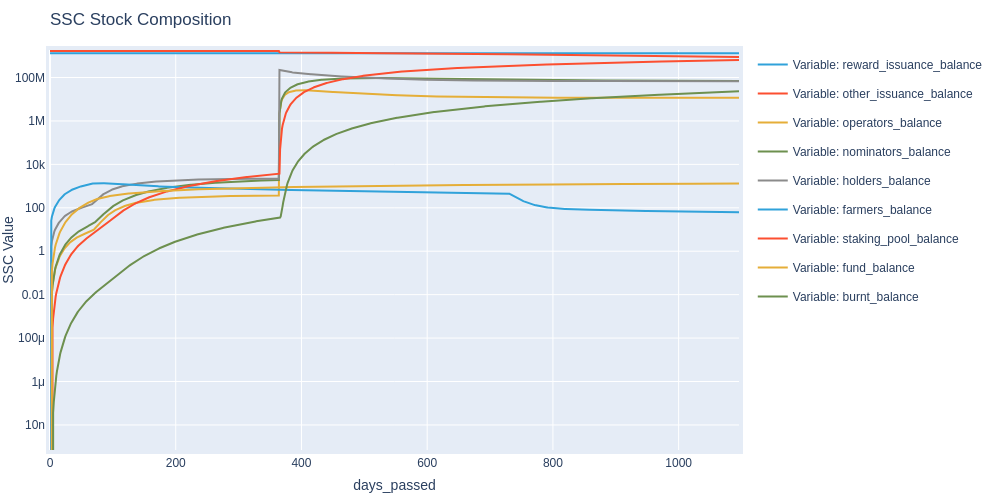

In [8]:
chart = sim_df.hvplot(
    x="days_passed", 
    y=[c for c in sim_df.columns if "_balance" in c],
    title="SSC Stock Composition", logy=True, 
    ylabel="SSC Value", width=1000, height=500,
)

pio.show(hv.render(chart, backend='plotly'))

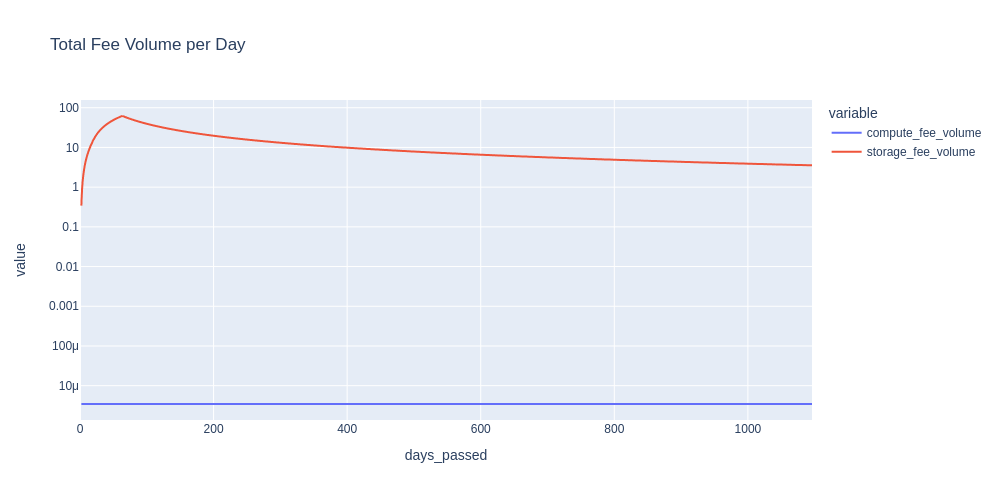

In [9]:
fig = px.line(sim_df, 
        x='days_passed', 
        y=[el for el in sim_df.columns if "volume" in el],
        title='Total Fee Volume per Day',
        log_y=True)
fig.update_layout(width=1000, height=500)
fig.show()

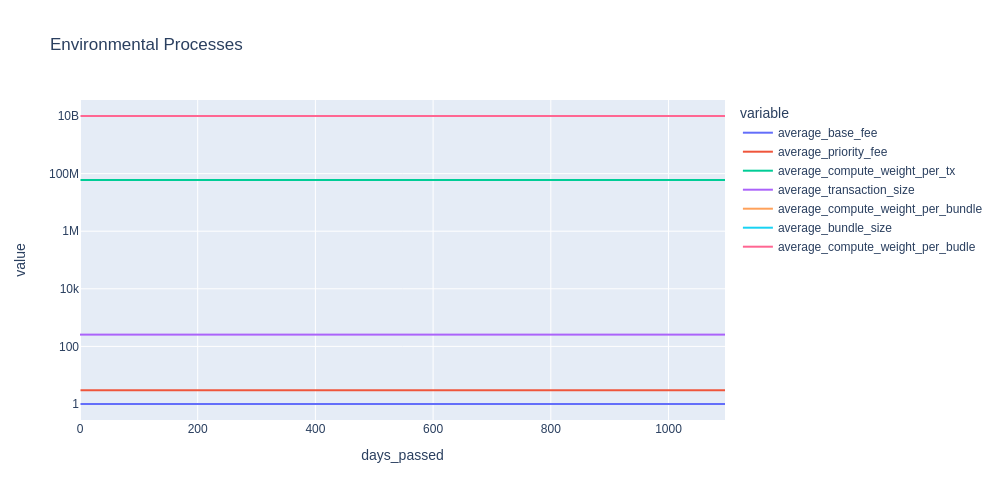

In [10]:
fig_df = sim_df.melt(id_vars=['days_passed'], value_vars=[el for el in sim_df.columns if "average" in el])


fig = px.line(fig_df, 
        x='days_passed', 
        y='value',
        color='variable',
        title='Environmental Processes',
        log_y=True)

fig.update_layout(width=1000, height=500)
fig.show()

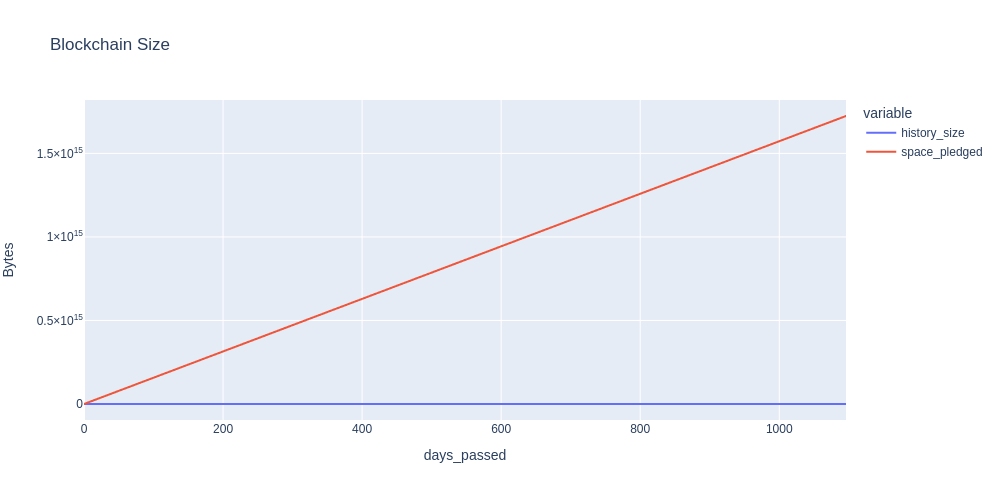

In [11]:
fig = px.line(sim_df, 
        x='days_passed', 
        y=['history_size', 'space_pledged'],
        title='Blockchain Size',
        labels={'value': 'Bytes'})
fig.update_layout(width=1000, height=500)
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

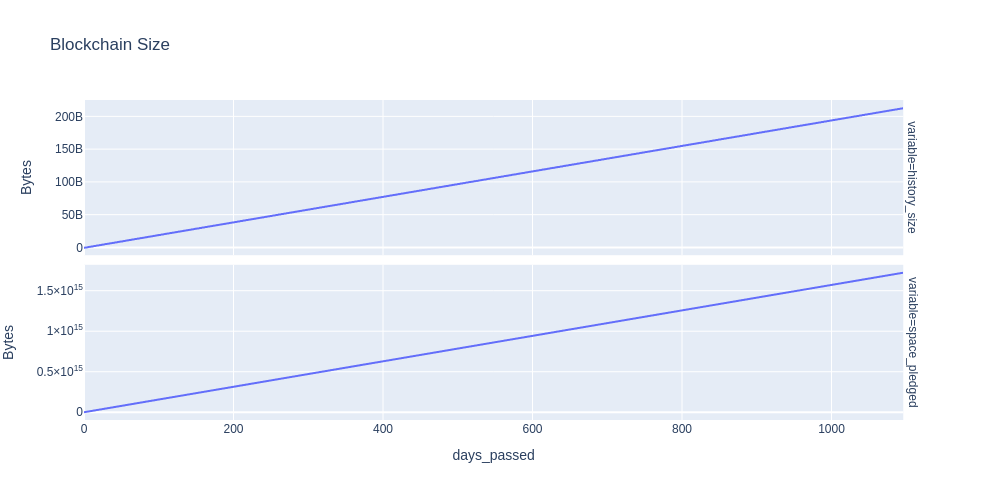

In [12]:
fig_df = sim_df.melt(id_vars=['days_passed'], 
                     value_vars=['history_size', 'space_pledged'])

fig = px.line(fig_df, 
        x='days_passed', 
        y='value',
        facet_row='variable',
        title='Blockchain Size',
        labels={'value': 'Bytes'})
fig.update_layout(width=1000, height=500)
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

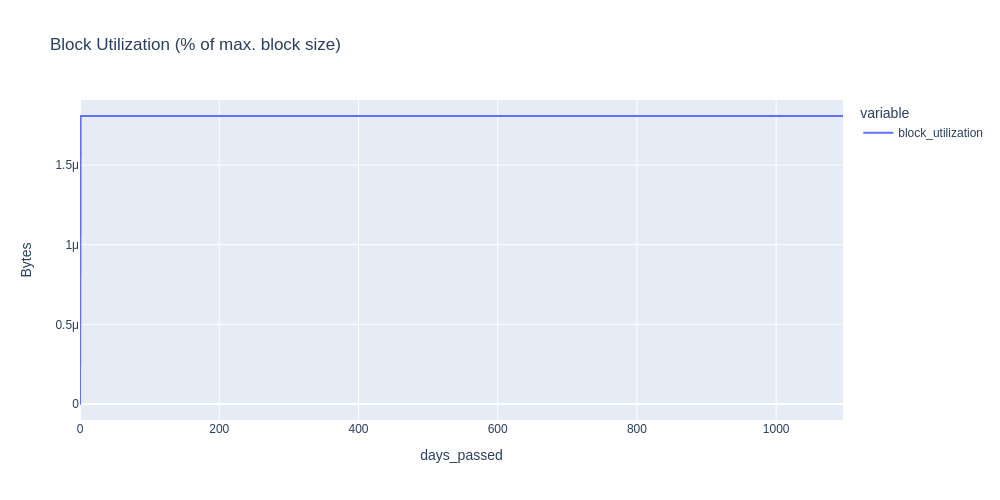

In [13]:
fig = px.line(sim_df, 
        x='days_passed', 
        y=['block_utilization'],
        title='Block Utilization (% of max. block size)',
        labels={'value': 'Bytes'})
fig.update_layout(width=1000, height=500)
fig.show()

### Scoped KPIs


2024-01-02 12:18:25 - subspace-digital-twin - INFO
------------subspace-digital-twin------------


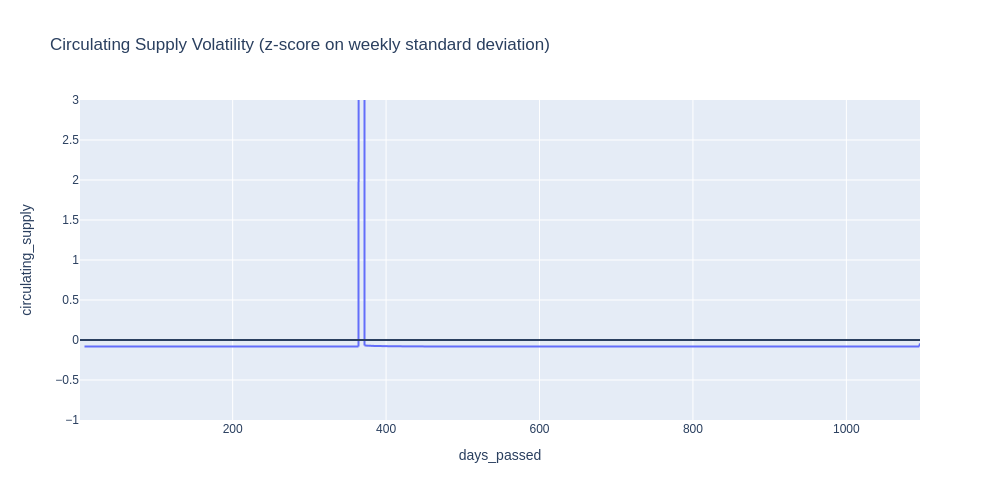

In [14]:
from subspace_model.experiments.metrics import *
m_df = sim_df.set_index('days_passed')
s = window_volatility(m_df.circulating_supply.diff()).reset_index()

fig = px.line(s, 
        x='days_passed', 
        y='circulating_supply',
        title='Circulating Supply Volatility (z-score on weekly standard deviation)')
fig.add_hline(0)
fig.update_layout(width=1000, height=500, yaxis_range=[-1, 3])
fig.show()

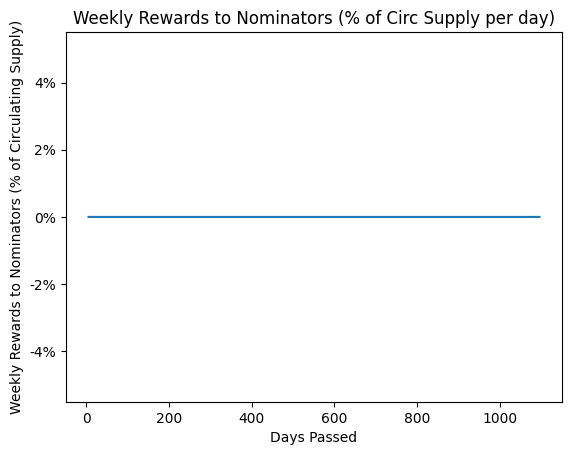

In [15]:
n_days = 7
fig_df = sim_df.set_index('days_passed')
s = fig_df.rewards_to_nominators.rolling(n_days).sum() / fig_df.circulating_supply.rolling(n_days).mean()
ax = s.plot()
plt.title("Weekly Rewards to Nominators (% of Circ Supply per day)")
plt.xlabel('Days Passed')
plt.ylabel('Weekly Rewards to Nominators (% of Circulating Supply)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.show()

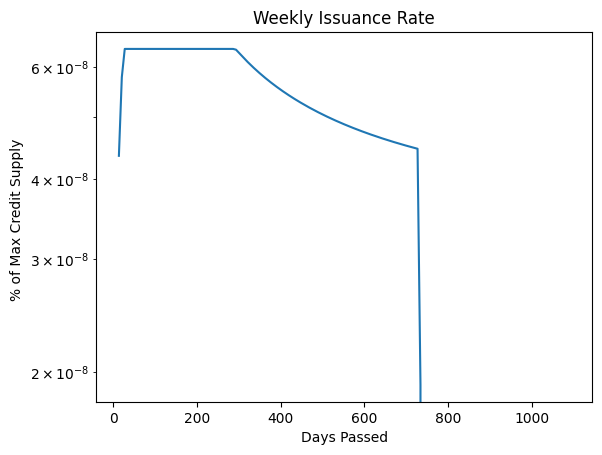

In [16]:
n = 7
s = fig_df.reward_issuance_balance.diff() * -1.0
s /= fig_df.max_credit_supply
s = s.rolling(n).sum()[n-1::n]

ax = s.plot(x='days_passed', y='reward_issuance_balance', logy=True)
plt.title("Weekly Issuance Rate")
plt.xlabel('Days Passed')
plt.ylabel('% of Max Credit Supply ')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
plt.show()

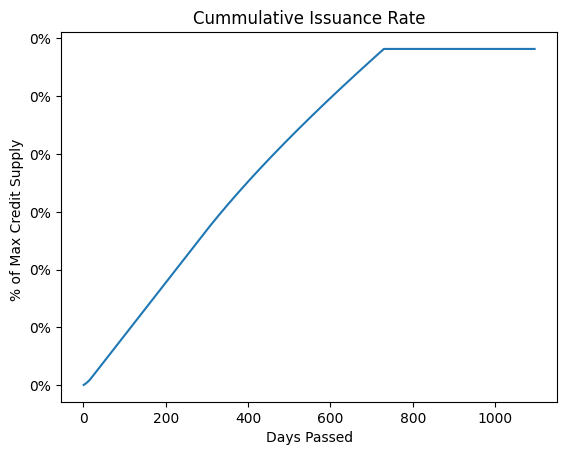

In [17]:
n = 7
s = fig_df.reward_issuance_balance.diff() * -1.0
s /= fig_df.max_credit_supply
s = s.cumsum()

ax = s.plot(x='days_passed', y='reward_issuance_balance')
plt.title("Cummulative Issuance Rate")
plt.xlabel('Days Passed')
plt.ylabel('% of Max Credit Supply ')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.show()